In [20]:
%matplotlib inline
import seaborn as sns

import findspark
import os
findspark.init()

import pyspark
from pyspark import SparkContext
from pyspark import SparkFiles
from pyspark import sql
from pyspark import SparkConf
from pyspark import StorageLevel

from pyspark.sql import SQLContext, HiveContext

from pyspark.sql import Row
from pyspark.sql import DataFrameWriter
from pyspark.sql import DataFrameReader
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import GroupedData
from pyspark.sql.functions import UserDefinedFunction

from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation  import *
from pyspark.mllib.linalg import *
from pyspark.mllib.linalg import VectorUDT, MatrixUDT, Vectors, Matrices

from pyspark.mllib.tree import RandomForest, RandomForestModel, GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

from functools import partial
import numpy as np

from datasu.auc import *
from datasu.dicts import *
from datasu.files import *
from datasu.pandas import *
from datasu.persist import *
from datasu.spark import *
from datasu.patsy import *


import pandas as pd

In [2]:
conf = SparkConf()
conf.set('spark.executor.memory', '8g')
conf.set('spark.driver.memory', '12g')
conf.set('spark.python.worker.memory', '2g')
conf.set("spark.driver.maxResultSize", "5g")
conf.set("spark.executor.instances", '4')
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set('spark.executor.extraJavaOptions', '-XX:+PrintGCDetails -XX:+UseCompressedOops')

conf.setAppName('logr3')
conf.getAll()

[(u'spark.serializer', u'org.apache.spark.serializer.KryoSerializer'),
 (u'spark.executor.instances', u'4'),
 (u'spark.app.name', u'logr3'),
 (u'spark.master', u'spark://spark1.ea.lab:7077'),
 (u'spark.driver.memory', u'12g'),
 (u'spark.python.worker.memory', u'2g'),
 (u'spark.submit.pyFiles',
  u'/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,/home/ds/.ivy2/jars/org.apache.commons_commons-csv-1.1.jar,/home/ds/.ivy2/jars/com.univocity_univocity-parsers-1.5.1.jar'),
 (u'spark.executor.extraJavaOptions',
  u'-XX:+PrintGCDetails -XX:+UseCompressedOops'),
 (u'spark.jars',
  u'file:/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,file:/home/ds/.ivy2/jars/org.apache.commons_commons-csv-1.1.jar,file:/home/ds/.ivy2/jars/com.univocity_univocity-parsers-1.5.1.jar'),
 (u'spark.executor.memory', u'8g'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.driver.maxResultSize', u'5g'),
 (u'spark.files',
  u'file:/home/ds/.ivy2/jars/com.databricks_spark-csv_2.10-1.3.0.jar,fil

In [58]:
try:
    sc.stop()
except:
    print 'spark context not exists'

In [3]:
sc = pyspark.SparkContext(conf=conf)
sqc = pyspark.SQLContext(sc)
sqlContext = sqc

In [4]:
csv_reader = sqc.read.format('com.databricks.spark.csv').options(header='true', inferschema='true')

## LOAD DATA


In [5]:
base_data_path = '/home/ds/dev/data/Kagle-ValuesShoppers/'

### load spark

In [6]:
spark_data_path = 'file://'+ base_data_path + 'spark_data/'
transactions_name = 'transactions'

In [7]:
def withColumnUdf(df, column, udf, alias=None):
    return df.withColumn(column, udf(column).alias(column))

In [8]:
# ddf_trans_agg_history = csv_reader.load(spark_data_path+'ddf_trans_agg_history', samplingRatio=None)
ddf_offers__onehot_brand_fs1 = csv_reader.load(spark_data_path+'ddf_offers__onehot_brand_fs1', samplingRatio=None)
ddf_offers_subm__onehot_brand_fs1 = csv_reader.load(spark_data_path+'ddf_offers_subm__onehot_brand_fs1', samplingRatio=None)

ddf_offers__onehot_brand_fs01 = csv_reader.load(spark_data_path+'ddf_offers__onehot_brand_fs01', samplingRatio=None)
ddf_offers_subm__onehot_brand_fs01 = csv_reader.load(spark_data_path+'ddf_offers_subm__onehot_brand_fs01', samplingRatio=None)


In [19]:
string_to_vector = F.UserDefinedFunction(Vectors.parse, VectorUDT(), 'string_to_vector')

In [21]:
ddf_offers__onehot_brand_fs1 = ddf_offers__onehot_brand_fs1.withColumn('features', string_to_vector('features'))
ddf_offers_subm__onehot_brand_fs1 = ddf_offers_subm__onehot_brand_fs1.withColumn('features', string_to_vector('features'))
ddf_offers__onehot_brand_fs01 = ddf_offers__onehot_brand_fs01.withColumn('features', string_to_vector('features'))
ddf_offers_subm__onehot_brand_fs01 = ddf_offers_subm__onehot_brand_fs01.withColumn('features', string_to_vector('features'))

In [22]:
ddf_offers__onehot_brand_fs1.columns, ddf_offers_subm__onehot_brand_fs1.columns

(['customer_id', 'features', 'repeater'], ['customer_id', 'features'])

In [ ]:
ddf_offers__onehot_brand_fs1.printSchema()

In [ ]:
ddf_offers__onehot_brand_fs1.rdd.getNumPartitions()

In [ ]:
ddf_offers__onehot_brand_fs1.show(2)

In [ ]:
ddf_offers__onehot_brand_fs1.count()

In [ ]:
ddf_offers__onehot_brand_fs01.count()

## prepare features

In [ ]:
# categorical_cols = ['chain','market','category','company','brand']
# num_cols = ['offervalue','quantity']

# ddf_offers__trans_agg_brand_fs1 = convert_columns_to_type(ddf_offers__trans_agg_brand_fs1, categorical_cols, StringType)
# ddf_offers__trans_agg_brand_fs01 = convert_columns_to_type(ddf_offers__trans_agg_brand_fs01, categorical_cols, StringType)
# ddf_offers_submission__trans_agg_brand_fs1 = convert_columns_to_type(ddf_offers_submission__trans_agg_brand_fs1, categorical_cols, StringType)
# ddf_offers_submission__trans_agg_brand_fs01 = convert_columns_to_type(ddf_offers_submission__trans_agg_brand_fs01, categorical_cols, StringType)

# build pipes

### build prepare pipe

In [ ]:
(agg_cols + categorical_cols + num_cols)

In [23]:
# assembler1 = VectorAssembler(inputCols=categorical_cols, outputCol="cat_features1")
# assembler = VectorAssembler(inputCols=agg_cols + categorical_cols + num_cols, outputCol="features1")

featureIndexer = VectorIndexer(inputCol="features", outputCol="cat_features", maxCategories=4)
# assembler2 = VectorAssembler(inputCols=num_cols+['cat_features', 'features'], outputCol="features2")

labelIndexer = StringIndexer(inputCol="repeater", outputCol="label")

pipe_transform1 = Pipeline(stages=[featureIndexer, labelIndexer])
    
# px = PolynomialExpansion(degree=2, inputCol="indexedFeatures", outputCol="features_poly")

# pipe_prepare1 = Pipeline(stages=[std_scale, px])
# pipe_prepare1 = Pipeline(stages=[std_scale])

### Dec. Tree

In [24]:
rf1 = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=5, maxBins=50)

pipe_rf1 = Pipeline(stages=[rf1])

### Logr

In [ ]:
lr1 = LogisticRegression(featuresCol="features_scaled", labelCol="label", predictionCol="prediction", regParam=0.1, elasticNetParam=0.3)

pipe_lr1 = Pipeline(stages=[lr1])

## Fit models

In [41]:
ddf_data_hist = ddf_offers__onehot_brand_fs01
ddf_data_subm = ddf_offers_subm__onehot_brand_fs01


In [42]:
ddf_data_subm = ddf_data_subm.withColumn('repeater',F.lit('f'))
# ddf_data_hist = ddf_data_hist.drop('repeattrips')

ddf_data_union = ddf_data_hist.unionAll(
                               ddf_data_subm.select(*ddf_data_hist.columns))

ddf_data_union = ddf_data_union.drop('customer_id')

In [43]:
model_transform1 = pipe_transform1.fit(ddf_data_union)

In [44]:
ddf_data = model_transform1.transform(ddf_data_hist)
ddf_data = ddf_data.select(['features','label']) #, 'repeattrips'])

In [45]:
ddf_data_train, ddf_data_test = ddf_data.randomSplit([0.7, 0.3])


In [46]:
ddf_data_train.groupBy('label').count().collect()

[Row(label=1.0, count=30380), Row(label=0.0, count=81617)]

In [47]:
model_rf1 = pipe_rf1.fit(ddf_data_train) #, params={'weightCol':"repeattrips"})


In [48]:
ddf_data_test_res1 = model_rf1.transform(ddf_data_test, params={'threshold':0.3})

In [49]:
df_data_test_res1 = ddf_data_test_res1.select(['rawPrediction', get_index_from_vector()('probability', F.lit(1)).alias('probability'), 'prediction', 'label']).toPandas()

In [50]:
df_data_test_res1.head()

,rawPrediction,probability,prediction,label
0,"[15.961674344, 4.03832565601]",0.201916,0,0
1,"[16.1994414377, 3.80055856233]",0.190028,0,1
2,"[15.6551720213, 4.34482797869]",0.217241,0,0
3,"[16.060237432, 3.93976256796]",0.196988,0,0
4,"[15.9600288001, 4.03997119989]",0.201999,0,0


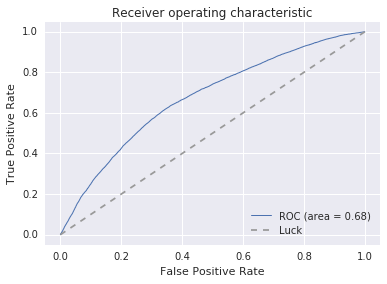

In [51]:
plot_auc(df_data_test_res1.label, df_data_test_res1.probability.values)

### cross-validation

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(ddf_data_test_res1)
print("Test Error = %g" % (1.0 - accuracy))

In [ ]:
grid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator=pipe_rf1, estimatorParamMaps=grid, evaluator=evaluator)

cvModel = cv.fit(ddf_data_train)
evaluator.evaluate(cvModel.transform(ddf_data_train))

### fit big data!!!

In [ ]:
ddf_trans_agg_history = ddf_trans_agg_history.drop('customer_id')

In [ ]:
ddf_trans_agg_history.printSchema

In [ ]:
ddf_offers_union__trans_aggs.printSchema

In [ ]:
ddf_offers_union__trans_aggs.select('repeater').show(5)

In [ ]:
ddf_trans_agg_history_union_offers = ddf_trans_agg_history.unionAll(ddf_offers_union__trans_aggs.select(*ddf_trans_agg_history.columns))
ddf_trans_agg_history_union_offers.columns

In [ ]:
model_transform1 = pipe_transform1.fit(ddf_trans_agg_history_union_offers)

In [ ]:
ddf_data = model_transform1.transform(ddf_trans_agg_history)
ddf_data = ddf_data.select(['features','label']) #, 'repeattrips'])

In [ ]:
ddf_data_train = ddf_data

In [ ]:
ddf_data_test = model_transform1.transform(ddf_offers__trans_aggs)

In [ ]:
# ddf_data_train, ddf_data_test = ddf_data.randomSplit([0.7, 0.3])

In [ ]:
ddf_data.groupBy('label').count().collect()

In [ ]:
ddf_trans_agg_history_union_offers.groupBy('repeater').count().collect()

In [ ]:
model_rf1 = pipe_rf1.fit(ddf_data_train) #, params={'weightCol':"repeattrips"})

In [ ]:
ddf_data_test_res1 = model_rf1.transform(ddf_data_test, params={'threshold':0.3})

In [ ]:
ddf_data_test_res1 = ddf_data_test_res1.select(['rawPrediction', get_index_from_vector()('probability', F.lit(1)).alias('probability'), 'prediction', 'label'])

In [ ]:
# df_data_test_res1 = ddf_data_test_res1.sample(False, fraction=0.05).toPandas()
df_data_test_res1 = ddf_data_test_res1.toPandas()

In [ ]:
df_data_test_res1.head()

In [ ]:
plot_auc(df_data_test_res1.label, df_data_test_res1.probability.values)

### submission

In [52]:
ddf_data_submission = model_transform1.transform(ddf_data_subm).select(['customer_id','features'])

In [53]:
ddf_data_submission_res1 = model_rf1.transform(ddf_data_submission)

In [54]:
df_data_submission_res1 = ddf_data_submission_res1.select(
                [F.col('customer_id').alias('id'), get_index_from_vector()('probability', F.lit(1)).alias('repeatProbability')]).toPandas()

In [55]:
df_data_submission_res1.head()

,id,repeatProbability
0,71933039,0.284632
1,73660439,0.268584
2,84196639,0.272736
3,88542039,0.268474
4,91883639,0.274076


In [57]:
df_data_submission_res1.to_csv(path_or_buf=base_data_path+'submission/'+'submission_spark20_rf1', index=False)

## Other

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
output = ParamGridBuilder() \
         .baseOn({lr.labelCol: 'l'}) \
         .baseOn([lr.predictionCol, 'p']) \
         .addGrid(lr.regParam, [1.0, 2.0]) \
         .addGrid(lr.maxIter, [1, 5]) \
         .build()
            
expected = [
         {lr.regParam: 1.0, lr.maxIter: 1, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 2.0, lr.maxIter: 1, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 1.0, lr.maxIter: 5, lr.labelCol: 'l', lr.predictionCol: 'p'},
         {lr.regParam: 2.0, lr.maxIter: 5, lr.labelCol: 'l', lr.predictionCol: 'p'}]

len(output) == len(expected)
all([m in expected for m in output])


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.linalg import Vectors
dataset = sqlContext.createDataFrame(
     [(Vectors.dense([0.0]), 0.0),
      (Vectors.dense([0.4]), 1.0),
      (Vectors.dense([0.5]), 0.0),
      (Vectors.dense([0.6]), 1.0),
      (Vectors.dense([1.0]), 1.0)] * 10,
     ["features", "label"])
lr = LogisticRegression()

grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(dataset)
evaluator.evaluate(cvModel.transform(dataset))

### play with RFormula

In [ ]:
df = sqc.createDataFrame([
     (1.0, 1.0, "a","q"),
     (0.0, 2.0, "b","w"),
     (0.0, 3.0, "a","q"),    
 ], ["y", "x", "cat1","cat2"])
df.show()


In [ ]:
rf = RFormula(formula="y ~ cat1", featuresCol="features", labelCol="label")
df1 = rf.fit(df).transform(df)
df1.show()

rf = RFormula(formula="y ~ cat1+cat2", featuresCol="features", labelCol="label")
df2 = rf.fit(df).transform(df)
df2.show()

rf = RFormula(formula="y ~ cat1:cat2", featuresCol="features", labelCol="label")
df3 = rf.fit(df).transform(df)
df3.show()

rf = RFormula(formula="y ~ cat1:x + cat2:x", featuresCol="features", labelCol="label")
df4 = rf.fit(df).transform(df)
df4.show()

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

scalerModel = scaler.fit(df1)
scalerModel.transform(df1).show()

In [ ]:
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors

df = sc.parallelize([
     Row(label=1.0, weight=2.0, features=Vectors.dense(1.0)),
     Row(label=0.0, weight=2.0, features=Vectors.sparse(1, [], []))]).toDF()
df.show()

In [ ]:

test0 = sc.parallelize([Row(features=Vectors.dense(-1.0))]).toDF()
result = model.transform(test0).head()
result.prediction

result.probability

result.rawPrediction

test1 = sc.parallelize([Row(features=Vectors.sparse(1, [0], [1.0]))]).toDF()
model.transform(test1).head().prediction

lr.setParams("vector")